Import Libraries

In [33]:
import io, os, json, gzip 
import pandas as pd
import numpy as np
from google.colab import files, drive
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from matplotlib import pyplot as pplt
%matplotlib inline

Import Dataset

In [6]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# unzip all data in local env
!unzip gdrive/My\ Drive/fer2013/fer2013.zip > /dev/null

       disgust  surprise  angry  fear   sad  happy  neutral
train      436      3171   3995  4097  4830   7215     4965

      disgust  surprise  angry  fear   sad  happy  neutral
test      111       831    958  1024  1247   1774     1233


<Axes: >

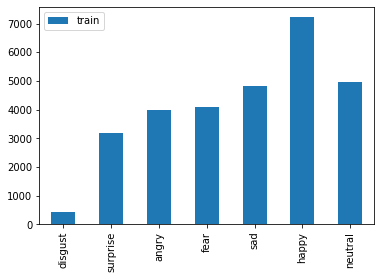

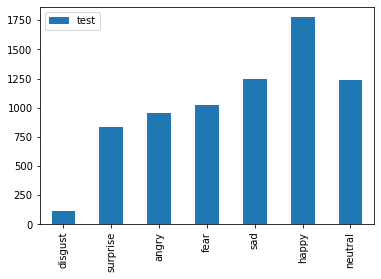

In [16]:
train_dir = 'train/'
test_dir = 'test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        if expression == ".ipynb_checkpoints":
          continue
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
train_count.transpose().plot(kind='bar')

Images as Matrix

In [21]:
# making n X m matrix
def img2np(path, list_of_filenames, size = (48,48)):
  # iterate through each file per emotion
  for fn in list_of_filenames:
      fp = path + fn
      current_image = image.load_img(fp, target_size = size, 
                                      color_mode = 'grayscale')
      # covert image to a matrix
      img_ts = image.img_to_array(current_image)
      # turn that into a vector / 1D array
      img_ts = [img_ts.ravel()]
      try:
          # concatenate different images
          full_mat = np.concatenate((full_mat, img_ts))
      except UnboundLocalError: 
          # if not assigned yet, assign one
          full_mat = img_ts
  return full_mat

surprise_imgs = [fn for fn in os.listdir(f'{train_dir}/surprise') if fn.endswith('.jpg')]
disgust_imgs = [fn for fn in os.listdir(f'{train_dir}/disgust') if fn.endswith('.jpg')]
fear_imgs = [fn for fn in os.listdir(f'{train_dir}/fear') if fn.endswith('.jpg')]
happy_imgs = [fn for fn in os.listdir(f'{train_dir}/happy') if fn.endswith('.jpg')]
neutral_imgs = [fn for fn in os.listdir(f'{train_dir}/neutral') if fn.endswith('.jpg')]
sad_imgs = [fn for fn in os.listdir(f'{train_dir}/sad') if fn.endswith('.jpg')]
angry_imgs = [fn for fn in os.listdir(f'{train_dir}/angry') if fn.endswith('.jpg')]

# run it on our folders
emotion = ['surprise', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'angry']
emotion_imgs = [surprise_imgs, disgust_imgs, fear_imgs, happy_imgs, neutral_imgs, sad_imgs, angry_imgs]

def matrixImages(emotion, emotion_imgs):
  result = []
  for i in range(len(emotion)):
    img = img2np(f'{train_dir}/{emotion[i]}/', emotion_imgs[i])
    result.append(img)
  return result

matrix_images = matrixImages(emotion, emotion_imgs)


Mean Images

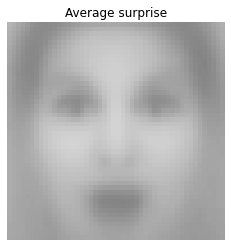

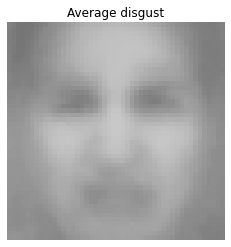

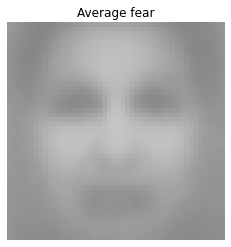

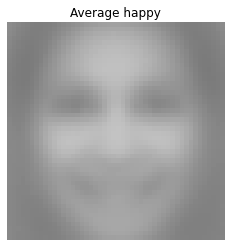

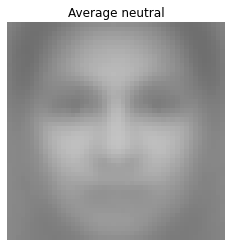

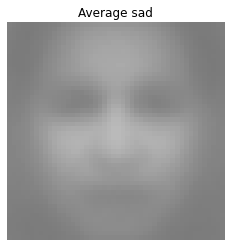

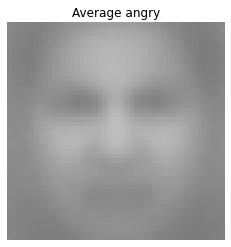

In [35]:
def find_mean_img(full_mat, title, size = (48,48)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r', alpha=1)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

for i in range(len(emotion)):
    find_mean_img(matrix_images[i], emotion[i])